# $k$ Nearest Neighbors

## Illustration of Nearest Neighbors

Arguably one of the simplest classification algorithm is $k$ nearest neighbors (KNN). Below figure portrays the algorithm's simplicity. We see a training set of five red and five blue dots, representing some label 1 and 0, respectively. The two axes represent two features, e.g. income and credit card balance. If we now add a new test data point $x_0$ (green dot), KNN will label this test data according to its $k$ closest neighbors. In below figure we set $k=3$. The three closest neighbors are: one blue dot and two red dots, resulting in estimated probabilities of 2/3 for the red class and 1/3 for the blue class. Hence KNN will predict that the new data point will belong to the red class. More so, based on the training set the algorithm is able to draw a decision boundary. (Note: In a classification settings with $j$ classes a *decision boundary* is a hyperplane that partitions the underlying vector space into $j$ sets, one for each class.). This is shown with the jagged line that separates background colors cyan (blue label) and light blue (red label). Given any possible pair of feature values, KNN labels the response along the drawn decision boundary. With $k=1$ the boundary line is very jagged. Increasing the number of $k$ will smoothen the decision boundary. This tells us that small values of $k$ will produce large variance but low bias, meaning that each new added training point might change the decision boundary line significantly but the decision boundary separates the training set (almost) correctly. As $k$ increases, variance decreases but bias increases. This is a manifestation of the Bias-Variance Trade-Off as discussed in the script ([Fortmann-Roe (2012)](http://scott.fortmann-roe.com/docs/BiasVariance.html)) and highlights the importance of selecting an adequate value of $k$ - a topic we will pick up in a future chapter.

<img src="Graphics/0207_KNN.png" alt="LinearRegClassification" style="width: 1000px;"/>

## Mathematical Description of KNN

Having introduced KNN illustratively, let us now define this in mathematical terms. Let our data set be $\{(x_1, y_1), (x_2, y_2), \ldots (x_n, y_n)\}$ with $x_i \in \mathbb{R}^p$ and $y_i \in \{0, 1\}\; \forall i \in \{1, 2, \ldots, n\}$. Based on the $k$ neighbors, KNN estimates the conditional probability for class $j$ as the fraction of points in $\mathcal{N}(k, x_0)$ (the set of the $k$ closest neighbors of $x_0$) whose response values equals $j$ (Russell and Norvig (2009)):

$$\begin{equation}
\Pr(Y = j | X = x_0) = \frac{1}{k} \sum_{i \in \mathcal{N}(k, x_0)} \mathbb{I}(y_i = j).
\end{equation}$$

Once the probability for each class $j$ is calculated, the  KNN classifier predicts a class label $\hat{y}_0$ for the new data point $x_0$ by maximizing the conditional probability (Batista and Silva (2009)).

$$\begin{equation}
\hat{y}_0 = \arg \max_{j} \frac{1}{k} \sum_{i \in \mathcal{N}(k,x_0)} \mathbb{I}(y_i = j)
\end{equation}$$

Selecting a new data point $x_0$'s nearest neighbors requires some notion of **distance measure**. Most researchers chose Minkowski's distance, which is often referred to as $L^m$ norm (Guggenbuehler (2015)). The distance between points $x_a$ and $x_b$ in $\mathbb{R}^p$ is then defined as follows (Russell and Norvig (2009)):

$$\begin{equation}
L^m (x_a, x_b) = \left(\sum_{i=1}^p |x_{a, i} - x_{b, i}|^m \right)^{1/m}
\end{equation}$$

Using $m=2$, above equation simplifies to the well known Euclidean distance and $m=1$ yields the Manhattten distance. Python's `sklearn` package, short for scikit-learn, offers [several other options](http://scikit-learn.org/stable/modules/generated/sklearn.neighbors.DistanceMetric.html) that we will not discuss. 

Beyond the pure distance measure, it is also possible to weight training data points relative to their distance from a certain point. In above figure distance is weighted uniformly. Alternatively one could weight points by the inverse of their distance (closer neighbors of a query point will have a greater influence than neighbors which are further away) or any other user-defined weighting function. For [further details check `sklearn`'s documentation](https://scikit-learn.org/stable/modules/generated/sklearn.neighbors.KNeighborsClassifier.html#sklearn.neighbors.KNeighborsClassifier) for details).

## Application: Predicting Share Price Movement

### Loading Data

The application of KNN is shown using simple stock market data. The idea is to predict a stock's movement based on simple features such as:
* `Lag1, Lag2`: log returns of the two previous trading days 
* `SMI`: SMI log return of the previous day

The response is a binary variable: if a stock closed above the previous day's closing price it equals 1, and 0 if it fell. We start by loading the necessary packages and stock data from a csv - a procedure we are well acquainted with by now. Thus comments are held short.

In [1]:
%matplotlib inline
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
plt.style.use('seaborn-whitegrid')
plt.rcParams['font.size'] = 14

In [2]:
# Import daily shares prices and select window
shsPr = pd.read_csv('Data/SMIDataDaily.csv', sep=',',
                     parse_dates=['Date'], dayfirst=True,
                     index_col=['Date'])
shsPr = shsPr['2017-06-30':'2012-06-01']
shsPr.head()

,ABBN,ADEN,BAER,CFR,CSGN,GEBN,GIVN,LHN,LONN,NESN,...,ROG,SCMN,SGSN,SLHN,SREN,UBSG,UHR,ZURN,SIK,SMI
Date,,,,,,,,,,,,,,,,,,,,,
2017-06-30,23.68,72.90,50.45,79.00,13.86,447.2,1918.0,54.90,207.3,83.45,...,244.2,462.7,2322.0,323.6,87.65,16.24,354.1,279.1,6160.0,8906.89
2017-06-29,23.63,72.85,51.30,78.60,14.10,446.0,1913.0,55.00,204.7,83.65,...,246.9,463.9,2310.0,323.3,87.80,16.36,353.4,276.3,6145.0,8944.04
2017-06-28,24.07,73.55,51.65,80.00,13.82,452.5,1927.0,56.35,207.5,85.40,...,251.2,464.9,2342.0,325.3,88.55,16.29,360.0,278.0,6195.0,9076.73
2017-06-27,24.40,73.70,51.65,80.20,13.74,453.8,1931.0,56.40,207.6,84.30,...,252.0,465.0,2355.0,322.7,88.80,16.00,362.0,281.7,6280.0,9072.92
2017-06-26,24.63,73.85,51.35,80.45,13.49,457.0,1947.0,56.25,208.2,85.65,...,251.7,469.3,2375.0,323.9,89.40,15.71,367.5,284.4,6310.0,9121.22


Having the data in a proper dataframe, we are now in a position to create the features and response values.

In [3]:
# Calculate log-returns and label responses: 
# 'direction' equals 1 if stock closed above 
# previous day and 0 if it fell.
today = np.log(shsPr / shsPr.shift(-1))
direction = np.where(today >= 0, 1, 0)

# Convert 'direction' to dataframe
direction = pd.DataFrame(direction, index=today.index, columns=today.columns)

# Lag1, 2: t-1 and t-2 returns; excl. smi (in last column)
Lag1 = np.log(shsPr.iloc[:, :-1].shift(-1) / shsPr.iloc[:, :-1].shift(-2))
Lag2 = np.log(shsPr.iloc[:, :-1].shift(-2) / shsPr.iloc[:, :-1].shift(-3))

# Previous day return for SMI index
smi  = np.log(shsPr.iloc[:, -1].shift(-1) / shsPr.iloc[:, -1].shift(-2))

### KNN Algorithm Applied

Now comes the difficult part. What we want to achieve is to run the KNN algorithm for every stock and for different hyperparameter $k$ and see how it performs. For this we do the following steps:

1. Create a feature matrix `X` containing `Lag1`, `Lag2` and `SMI` data for share i
2. Create a response vector `y` with binary direction values
3. Split data to training (before 2016-06-30) and test set (after 2016-06-30)
4. Run KNN for different values of $k$ (loop)
5. Write test score for given $k$ to matrix `scr`
6. Once we have run through all $k$'s we proceed with step 1. with share i+1

This means we need two loops. The first corresponds to the share (e.g. ABB, Adecco, etc.), the second runs the KNN algorithm for different values of $k$. 

The reason for this approach is that we are interested in finding any pattern/structure that would provide a successful trading strategy. There is obviously no free lunch. Predicting share price direction is by no means an easy task and we must be well aware that we are in for a difficult job here. If it were simple, neither one of us would be sitting here but run his own fund. But nonetheless, let us see how KNN performs and how homogeneous (or heterogeneous) the results are.

As usual our first step is to prepare the ground by loading the necessary package and defining some auxiliary variables. The KNN function we will be using is available through the `sklearn` (short for Scikit-learn) package. We only load the `neighbor` sublibrary which contains the needed KNN function called `KNeigborsClassifier()`. KNN is applied with the default distance metric: Euclidean distance (Minkowski's distance with $m=2$). If we would prefer another distance metric we would have to specify it ([see documentation](http://scikit-learn.org/stable/modules/generated/sklearn.neighbors.KNeighborsClassifier.html)).

In [4]:
# Import relevant functions
from sklearn import neighbors

# k = {1, 3, ..., 200}
k = np.arange(1, 200, 2)

# Array to store results in. Dimension is [k x m] 
# with m=20 for the 20 companies (excl. SMI)
scr = np.empty(shape=(len(k), len(shsPr.columns)-1))

In [5]:
for i in range(len(shsPr.columns)-1):
    
    # 1) Create matrix with feature values of stock i
    X = pd.concat([Lag1.iloc[:, i], Lag2.iloc[:, i], smi], axis=1)
    X = X[:-3]  # Drop last three rows with NaN (due to lag)
    
    # 2) Remove last three rows of response dataframe
    #    to have equal no. of rows for features and response
    y = direction.iloc[:, i]
    y = y[:-3]
    
    # 3) Split data into training set...
    X_train = X['2016-06-30':]
    y_train = y['2016-06-30':]
    # ...and test set.
    X_test = X[:'2016-07-01']
    y_test = y[:'2016-07-01']
    
    # Convert responses to 1xN array (with .ravel() function)
    y_train = y_train.values.ravel()
    y_test  = y_test.values.ravel()
    
    for j in range(len(k)):
        
        # 4) Run KNN
        # Instantiate KNN class
        knn = neighbors.KNeighborsClassifier(n_neighbors=k[j])
        # Fit KNN classifier using training set
        knn = knn.fit(X_train, y_train)
        
        # 5) Extract test score for k[j]
        scr[j, i] = knn.score(X_test, y_test)

In [6]:
# Convert data to pandas dataframe
tickers = shsPr.columns
scr = pd.DataFrame(scr, index=k, columns=tickers[:-1])

In [7]:
scr.head()

,ABBN,ADEN,BAER,CFR,CSGN,GEBN,GIVN,LHN,LONN,NESN,NOVN,ROG,SCMN,SGSN,SLHN,SREN,UBSG,UHR,ZURN,SIK
1,0.462451,0.533597,0.521739,0.513834,0.509881,0.533597,0.498024,0.498024,0.505929,0.411067,0.549407,0.553360,0.513834,0.521739,0.509881,0.470356,0.490119,0.549407,0.498024,0.529644
3,0.478261,0.470356,0.529644,0.486166,0.577075,0.533597,0.525692,0.482213,0.525692,0.486166,0.517787,0.573123,0.486166,0.517787,0.541502,0.450593,0.490119,0.557312,0.517787,0.513834
5,0.498024,0.494071,0.537549,0.494071,0.525692,0.573123,0.537549,0.474308,0.501976,0.486166,0.525692,0.513834,0.466403,0.501976,0.521739,0.482213,0.494071,0.553360,0.533597,0.509881
7,0.517787,0.486166,0.505929,0.498024,0.505929,0.553360,0.525692,0.517787,0.474308,0.509881,0.513834,0.482213,0.470356,0.509881,0.525692,0.466403,0.490119,0.561265,0.533597,0.509881
9,0.553360,0.478261,0.505929,0.470356,0.486166,0.533597,0.505929,0.513834,0.458498,0.462451,0.545455,0.486166,0.462451,0.501976,0.501976,0.470356,0.490119,0.517787,0.482213,0.470356


### Results & Analysis

Now let's see the results in an overview. 

In [8]:
scr.describe()

,ABBN,ADEN,BAER,CFR,CSGN,GEBN,GIVN,LHN,LONN,NESN,NOVN,ROG,SCMN,SGSN,SLHN,SREN,UBSG,UHR,ZURN,SIK
count,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000
mean,0.553202,0.506798,0.515968,0.508577,0.517431,0.499763,0.533320,0.492016,0.537510,0.519960,0.546877,0.513043,0.479051,0.516996,0.490514,0.520791,0.489289,0.507352,0.553557,0.530040
std,0.031183,0.010579,0.023187,0.024694,0.016666,0.020266,0.013498,0.019546,0.027272,0.020842,0.018939,0.016882,0.019902,0.020634,0.020150,0.017837,0.014962,0.027736,0.020282,0.028188
min,0.462451,0.470356,0.462451,0.454545,0.446640,0.458498,0.498024,0.450593,0.458498,0.411067,0.505929,0.474308,0.446640,0.474308,0.450593,0.450593,0.438735,0.454545,0.482213,0.466403
25%,0.529644,0.500988,0.501976,0.493083,0.509881,0.486166,0.525692,0.477273,0.529644,0.509881,0.533597,0.501976,0.462451,0.501976,0.474308,0.516798,0.482213,0.486166,0.545455,0.512846
50%,0.557312,0.505929,0.517787,0.509881,0.517787,0.498024,0.533597,0.490119,0.547431,0.525692,0.545455,0.513834,0.476285,0.521739,0.494071,0.525692,0.490119,0.501976,0.557312,0.525692
75%,0.581028,0.513834,0.533597,0.525692,0.525692,0.513834,0.537549,0.505929,0.553360,0.533597,0.561265,0.525692,0.490119,0.533597,0.501976,0.533597,0.498024,0.525692,0.569170,0.546443
max,0.600791,0.533597,0.569170,0.557312,0.577075,0.573123,0.573123,0.541502,0.577075,0.549407,0.592885,0.573123,0.541502,0.561265,0.541502,0.545455,0.521739,0.573123,0.592885,0.581028


Following finance theory, returns should be distributed symmetrically. Thus the simplest guess would be to expect a share price to increase on 50% of the days and to decrease on the remaining 50%. Similar to guessing a coin flip, if we would guess an 'up' movement for every day, we obviously would - in the long run - be correct 50% of the times. This would make for a score of 50%. 

Looking in that light at the above summary, we see some very interesting results. For 13 out of 20 stocks KNN produces test scores of > 50% for even the 0.25th percentile. Let's plot the ones with the highest test-scores (ABBN, NOVN, SIK and ZURN) to see at what value of $k$ the best test-score is achieved.

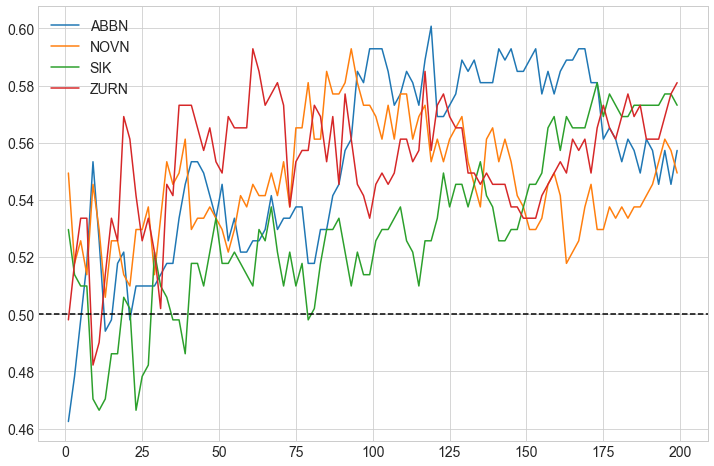

In [9]:
nms = ['ABBN', 'NOVN', 'SIK', 'ZURN']

plt.figure(figsize=(12, 8))
for col in nms:
    scr[col].plot(legend=True)
plt.axhline(0.50, c='k', ls='--');

For ABB and Novartis the max. score is around $k=100$ while for Sika and Zurich it is between 177 - 185. Furthermore, it seems interesting that for ABB, Novartis and Zurich the test score was barely below 50%. If this is indeed a pattern we would have found a trading strategy, wouldn't we? 

To further assess our results we look into KNN's prediction of ABB stock movements. For this we rerun our KNN classifier algorithm for ABB as before.

In [10]:
# 1) Create matrix with feature values of stock i
X = pd.concat([Lag1['ABBN'], Lag2['ABBN'], smi], axis=1)
X = X[:-3]  # Drop last three rows with NaN (due to lag)

In [11]:
# 2) Remove last three rows of response dataframe
#    to have equal no. of rows for features and response
y = direction['ABBN']
y = y[:-3]

In [12]:
# 3) Split data into training set...
X_train = X['2016-06-30':]
y_train = y['2016-06-30':]
# ...and test set.
X_test = X[:'2016-07-01']
y_test = y[:'2016-07-01']

# Convert responses to 1xN array (with .ravel() function)
y_train = y_train.values.ravel()
y_test  = y_test.values.ravel()

For ABB the maximum score is reached where $k=119$. You can check this with the `scr['ABBN'].idxmax()` command, which provides the index of the maximum value of the selected column. In our case, the index is equivalent to the value of $k$. Thus we run KNN with $k=119$.

In [13]:
# 4) Run KNN
# Instantiate KNN class for ABB with k=119
knn = neighbors.KNeighborsClassifier(n_neighbors=119)
# Fit KNN classifier using training set
knn = knn.fit(X_train, y_train)

# 5) Extract test score for ABB
scr_ABB = knn.score(X_test, y_test)
scr_ABB

0.6007905138339921

The score of 60.08% is the very same as what we have seen in above summary statistic. Nothing new so far. (Recall that the score is the total of correctly predicted outcomes.)

However, the alert reader should by now raise some questions regarding our assumption that 50% of the returns should have been positive. In the long run, this might be true. But our training sample contained only 1'018 records and of these 535 were positive. 

In [14]:
# Percentage of 'up' days in training set
y_train.sum() / y_train.size

0.5255402750491159

Therefore, if we would guess 'up' for every day of our test set and **given the distribution of classes in the test set is exactly as in our training set**, then we would predict the correct movement in 52.55% of the cases. So in that light, the predictive power of our KNN algorithm has to be put in perspective to the 52.55%.

In summary, our KNN algorithm has a score of 60.08%. Our best guess (based on the training set) would yield a score of 52.55%. This still displays that overall our KNN algorithm outperforms our best guess. Nonetheless, the margin is smaller than initially thought. 

### Confusion Matrix

There are more tools to assess the accuracy of an algorithm. We postpone the discussion of these tools to a later chapter and at this stage restrict ourselves to the discussion of a tool called "confusion matrix". 

A confusion matrix is a convenient way of displaying how our classifier performs. In binary classification (with e.g. response $y \in \{0, 1\}$) there are four prediction categories possible (Ting (2011)):

* **True positive**: True response value is 1, predicted value is 1 ("hit")
* **True negative**: True response value is 0, predicted value is 0 ("correct rejection")
* **False positive**: True response value is 0, predicted value is 1 ("False alarm", Type 1 error)
* **False negative**: True response value is 1, predicted value is 0 ("Miss", Type 2 error)

These information help us to understand how our (KNN) algorithm performed. There are different two ways of arranging confusion matrix. James et al. (2013) follow the convention that column labels indicate the true class label and rows the predicted response class. Others have it transposed such that column labels indicate predicted classes and row labels show true values. We will use the latter approach as it is more common.

<img src="Graphics/0207_ConfusionMatrixExplained.png" alt="ConfusionMatrixExplained" style="width: 800px;"/>

To run this in Python, we first predict the response value for each data entry in our test matrix `X_test`. Then we arrange the data in a suitable manner.

In [15]:
# Predict 'up' (=1) or 'down' (=0) for test set
pred = knn.predict(X_test)

In [16]:
# Store data in DataFrame
cfm = pd.DataFrame({'True direction': y_test,
                    'Predicted direction': pred})
cfm.replace(to_replace={0:'Down', 1:'Up'}, inplace=True)

# Arrange data to confusion matrix
print(cfm.groupby(['Predicted direction','True direction']) \
      .size().unstack('Predicted direction'))

Predicted direction  Down   Up
True direction                
Down                   31   83
Up                     18  121


As mentioned before, rows represent the true outcome and columns show what class KNN predicted. In 31 cases, the test set's true response was 'down' (in our case represented by 0) and KNN correctly predicted 'down'. 121 times KNN was correct in predicting an 'up' (=1) movement. 18 returns in the test set were positive but KNN predicted a negative return. And in 83 out of 253 cases KNN predicted an 'up' movement whereas in reality the stock price decreased. The KNN score of 60.08% for ABB is the sum of true positive and negative (31 + 121) in relation to the total number of predictions (253 = 31 + 18 + 83 + 121). The error rate is 1 - score or (18 + 83)/253.

Class-specific performance is also helpful to better understand results. The related terms are **sensitivity** and **specifity**. In the above case, sensitivity is the percentage of true 'up' movements that are identified. A good 88.1% (= 121 / (18 + 121)). The specifity is the percentage of 'down' movements that are correctly identified, here a poor 27.2% (= 31 / (31 + 83)). More on this in the next chapter.

Because confusion matrices are important to analyze results, `Scikit-learn` has its own [command to generate it](http://scikit-learn.org/stable/modules/generated/sklearn.metrics.confusion_matrix.html). It is part of the `metrics` sublibrary. The difficulty is that in contrast to above (manually generated) table, the function's output provides no labels. Therefore one must be sure to know which value are where. Here's the code to generate the confusion matrix.

In [17]:
from sklearn.metrics import confusion_matrix

# Confusion matrix
confusion_matrix(y_test, pred)

array([[ 31,  83],
       [ 18, 121]], dtype=int64)

In general it is tremendously helpful to visualize results. At the time of writing in February 2020, Anaconda shipped with `Sklearn` version 0.21.3. This `Sklearn` version unfortunately doesn't have a specific plotting function for the confusion matrix. However, on the package's website a [function code is provided](http://scikit-learn.org/stable/auto_examples/model_selection/plot_confusion_matrix.html) that does exactly this. Below their code is applied to our KNN results on ABB's stock price movement. (**See Post Script at the end for further details**)

In [18]:
import itertools
plt.style.use('default')

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

Confusion matrix, without normalization
[[ 31  83]
 [ 18 121]]


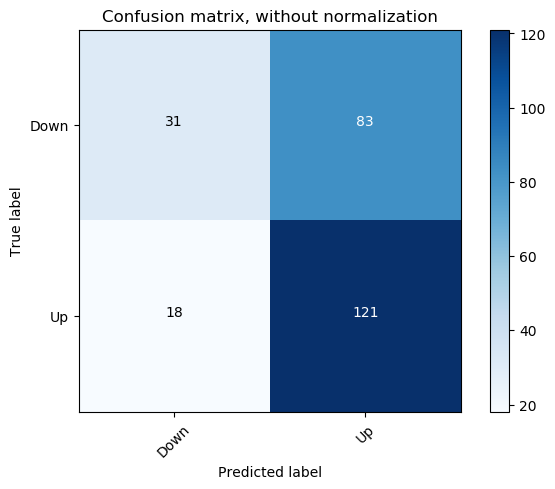

In [19]:
#plt.style.use('default')
# Compute confusion matrix
cfm_matrix = confusion_matrix(y_test, pred)
np.set_printoptions(precision=2)

# Plot non-normalized confusion matrix
plt.figure()
plot_confusion_matrix(cfm_matrix, classes=['Down', 'Up'],
                      title='Confusion matrix, without normalization');

Normalized confusion matrix
[[0.27 0.73]
 [0.13 0.87]]


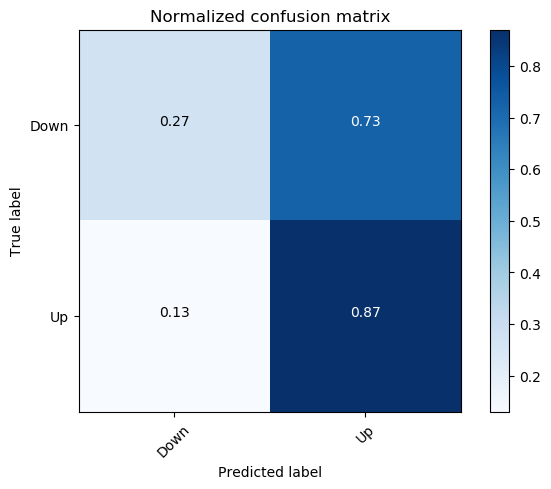

In [20]:
# Plot normalized confusion matrix
plt.figure()
plot_confusion_matrix(cfm_matrix, classes=['Down', 'Up'], normalize=True,
                      title='Normalized confusion matrix');

# Further Ressources


In writing this notebook, many ressources were consulted. For internet ressources the links are provided within the textflow above and will therefore not be listed again. Beyond these links, the following ressources were consulted and are recommended as further reading on the discussed topics:

* Batista, Gustavo, and Diego Furtado Silva, 2009, How k-nearest neighbor parameters affect its performance, in *Argentine Symposium on Artificial Intelligence*, 1–12, sn.
* Fortmann-Roe, Scott, 2012, Understanding the Bias-Variance Tradeoff from website, http://scott.fortmann-roe.com/docs/BiasVariance.html, 08/15/17.
* Guggenbuehler, Jan P., 2015, Predicting net new money using machine learning algorithms and newspaper articles, Technical report, University of Zurich, Zurich.
* James, Gareth, Daniela Witten, Trevor Hastie, and Robert Tibshirani, 2013, *An Introduction to Statistical Learning: With Applications in R* (Springer Science & Business Media, New York, NY).
* Müller, Andreas C., and Sarah Guido, 2017, *Introduction to Machine Learning with Python* (O’Reilly Media, Sebastopol, CA).
* Russell, Stuart, and Peter Norvig, 2009, *Artificial Intelligence: A Modern Approach* (Prentice Hall Press, Upper Saddle River, NJ).
* Ting, Kai Ming, 2011, Confusion matrix, in Claude Sammut, and Geoffrey I. Webb, eds., *Encyclopedia of Machine Learning* (Springer Science & Business Media, New York, NY).

# Post Script

Note that as of Scikit-Learn version 0.22.1 the confusion matrix plot was integrated into the sklearn distribution. Note however, that older Anaconda distributions might contain sklearn versions <= 0.22.1. Therefore in order to make use of it please check your sklearn version and update it if necessary (with `conda update scikit-learn` or `pip install --upgrade scikit-learn` in your shell). [Details see here](https://scikit-learn.org/stable/install.html#install-by-distribution).

In [21]:
import sklearn
sklearn.show_versions()


System:
    python: 3.6.10 |Anaconda, Inc.| (default, Jan  7 2020, 15:18:16) [MSC v.1916 64 bit (AMD64)]
executable: C:\Anaconda\python.exe
   machine: Windows-10-10.0.19041-SP0

Python dependencies:
       pip: 20.0.2
setuptools: 45.1.0.post20200127
   sklearn: 0.22.1
     numpy: 1.18.1
     scipy: 1.4.1
    Cython: 0.29.14
    pandas: 1.0.0
matplotlib: 3.1.2
    joblib: 0.14.1

Built with OpenMP: True


For details on what parameter can be adjusted see here. [Details see here](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.plot_confusion_matrix.html#sklearn.metrics.plot_confusion_matrix)

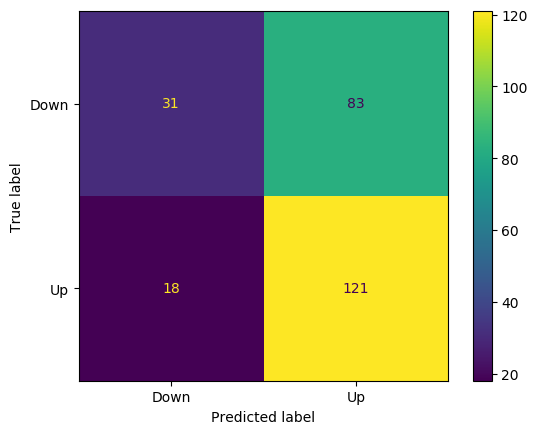

In [22]:
from sklearn.metrics import plot_confusion_matrix

# To use same colors use cmap = plt.cm.Blues 
# To plot the normalized figures, add normalize = 'true', 'pred', or 'all'
plot_confusion_matrix(estimator = knn, 
                      X = X_test, y_true = y_test,
                      display_labels = ['Down', 'Up'],
                      values_format = '.0f');